In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/mca#search=1~gallery~0~0'
raw = requests.get(url,headers=header)

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [4]:
import re # Regular expressions

brands = ['indian','yamaha','ducati','vespa','honda','harley','bmw','suzuki']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

In [5]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(17, 6)


,title,price,year,link,brand,age
0,2003 sv650s track bike,1700,2003.0,https://charlottesville.craigslist.org/mcy/d/w...,missing,22.0
1,2017 indian roadmaster,15495,2017.0,https://charlottesville.craigslist.org/mcy/d/c...,indian,8.0
2,2005 yamaha v-star,3750,2005.0,https://charlottesville.craigslist.org/mcy/d/s...,yamaha,20.0
3,2021 ktm390 adventure,5500,2021.0,https://charlottesville.craigslist.org/mcy/d/c...,missing,4.0
4,2017 ducati scrambler 800,6500,2017.0,https://charlottesville.craigslist.org/mcy/d/c...,ducati,8.0


count       17.000000
mean      6661.411765
std       7040.356934
min          0.000000
25%       2750.000000
50%       4750.000000
75%       6500.000000
max      24250.000000
Name: price, dtype: float64


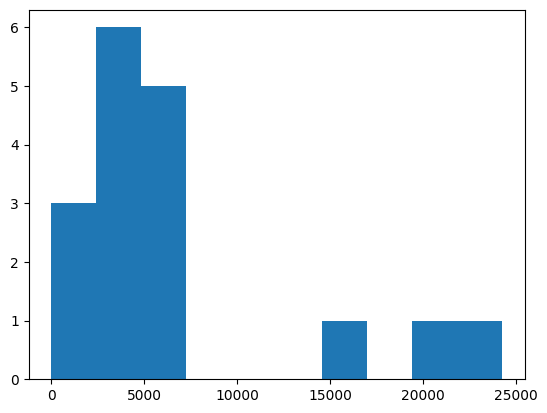

count    13.000000
mean     14.230769
std       6.508377
min       4.000000
25%       8.000000
50%      14.000000
75%      20.000000
max      22.000000
Name: age, dtype: float64


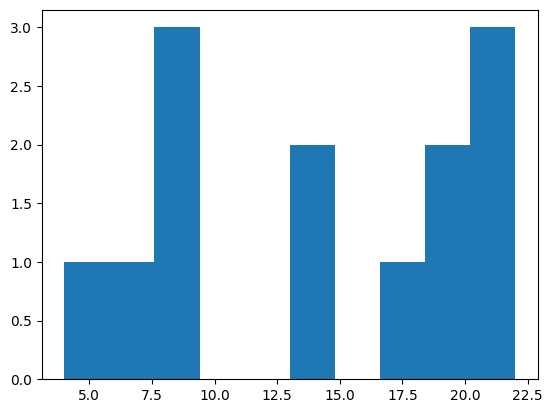

In [6]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [7]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
        count          mean           std      min       25%      50%   
brand                                                                   
bmw       3.0   4916.666667   1664.582030   3000.0   4375.00   5750.0   
ducati    1.0   6500.000000           NaN   6500.0   6500.00   6500.0   
harley    1.0   6500.000000           NaN   6500.0   6500.00   6500.0   
honda     2.0   1375.000000   1944.543648      0.0    687.50   1375.0   
indian    1.0  15495.000000           NaN  15495.0  15495.00  15495.0   
missing   5.0  10590.000000  11431.447852      0.0   1700.00   5500.0   
suzuki    1.0   2500.000000           NaN   2500.0   2500.00   2500.0   
vespa     2.0   4024.500000   1026.011940   3299.0   3661.75   4024.5   
yamaha    1.0   3750.000000           NaN   3750.0   3750.00   3750.0   

                            
              75%      max  
brand                       
bmw       5875.00   6000.0  
ducati    6500.00   6500.0  
harley    6500.00   6500.0  
honda     2062.50   2750.0  
indian   15495.00  15495.0  
missing  21500.00  24250.0  
suzuki    2500.00   2500.0  
vespa     4387.25   4750.0  
yamaha    3750.00   3750.0

In [8]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                   
        count       mean       std   min   25%   50%   75%   max
brand                                                           
bmw       3.0  17.666667  4.041452  14.0  15.5  17.0  19.5  22.0
ducati    1.0   8.000000       NaN   8.0   8.0   8.0   8.0   8.0
harley    1.0  22.000000       NaN  22.0  22.0  22.0  22.0  22.0
honda     1.0  19.000000       NaN  19.0  19.0  19.0  19.0  19.0
indian    1.0   8.000000       NaN   8.0   8.0   8.0   8.0   8.0
missing   3.0  11.666667  9.291573   4.0   6.5   9.0  15.5  22.0
suzuki    1.0  13.000000       NaN  13.0  13.0  13.0  13.0  13.0
vespa     1.0   7.000000       NaN   7.0   7.0   7.0   7.0   7.0
yamaha    1.0  20.000000       NaN  20.0  20.0  20.0  20.0  20.0

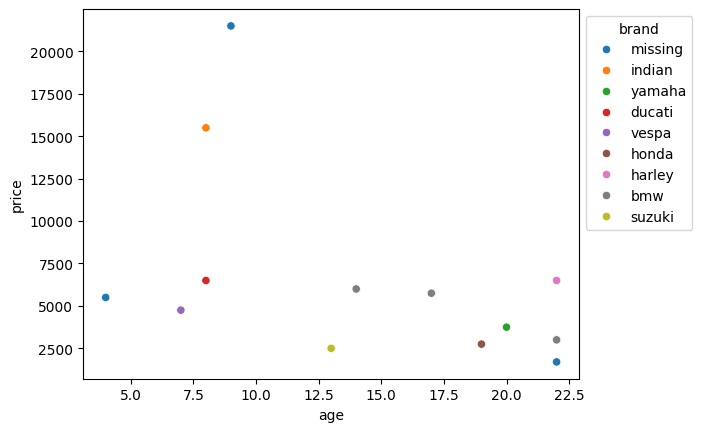

In [9]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   0.605387 -0.190151
log_age    -0.190151  0.300318
           log_price   log_age
log_price   1.000000 -0.492891
log_age    -0.492891  1.000000


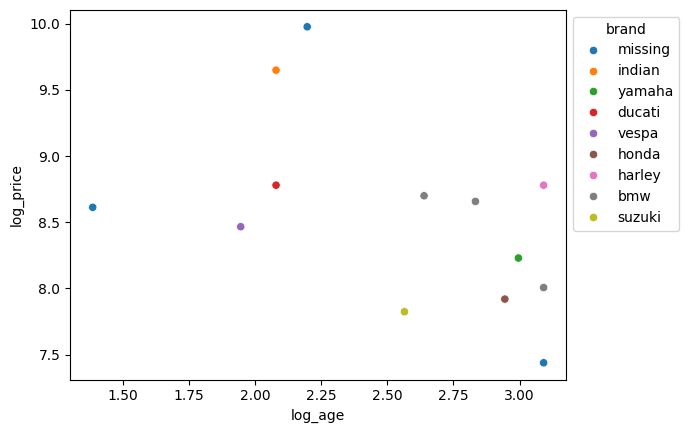

In [10]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

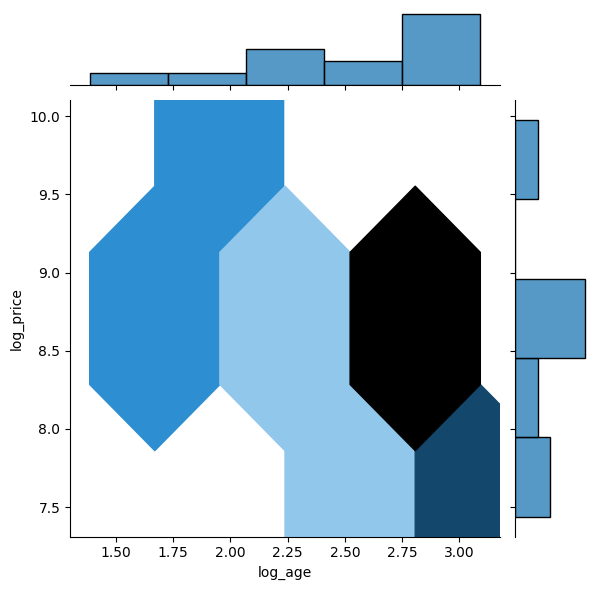

In [11]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')